In [1]:
from sklearn.model_selection import GridSearchCV
# The data may need to be scaled
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# To manipulate the datasets
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR

In [19]:
def transformData(dataframe):
    dataframe = dataframe.fillna(0)
    dataframe = dataframe.sort_values(by=['FixtureKey'])
    
    train['PTS'] = train['2PM']*2 + train['3PM']*3 + train['FTM']
    train['IsWinner'] = 0
    for i in range(0,len(train),2):
        if train.loc[i,'PTS'] > train.loc[i+1,'PTS']:
            train.loc[i,'IsWinner'] = 1
        else:
            train.loc[i+1,'IsWinner'] = 1
            
    dataframe['2PP'] = dataframe['2PM']/dataframe['2PA']
    dataframe['3PP'] = dataframe['3PM']/dataframe['3PA']
    dataframe['FTP'] = dataframe['FTM']/dataframe['FTA']
    
    dataframe['FGA'] = dataframe['2PA']+dataframe['3PA']
    dataframe['FGM'] = dataframe['2PM']+dataframe['3PM']

    dataframe['ASTR'] = dataframe['AST']/dataframe['FGM']
    dataframe['TASTR'] = dataframe['AST']/(dataframe['FGA']+(0.44*dataframe['FTA'])+dataframe['TOV'])
    dataframe['ATR'] = dataframe['AST']/dataframe['TOV']
    
    
    dataframe['FTR'] = dataframe['FTA']/dataframe['FGA']
    dataframe['FTCR'] = dataframe['FTR']*dataframe['FTP']
    dataframe['FGP'] = dataframe['FGM']/dataframe['FGA']
    dataframe['FGRR'] = dataframe['ORB']/dataframe['FGA']
    
    dataframe['FGPD'] = 0
    dataframe['ASTRD'] = 0
    dataframe['TASTRD'] = 0
    dataframe['FTRD'] = 0
    dataframe['FTCRD'] = 0
    dataframe['2PPD'] = 0
    dataframe['3PPD'] = 0
    dataframe['FTPD'] = 0
    dataframe['FGRRD'] = 0
    
    for i in range(0,len(dataframe),2):
        dataframe.loc[i,'FGPD'] = dataframe.loc[i,'FGP'] - dataframe.loc[i+1,'FGP']
        dataframe.loc[i+1,'FGPD'] = dataframe.loc[i+1,'FGP'] - dataframe.loc[i,'FGP']
        
        dataframe.loc[i,'ASTRD'] = dataframe.loc[i,'ASTR'] - dataframe.loc[i+1,'ASTR']
        dataframe.loc[i+1,'ASTRD'] = dataframe.loc[i+1,'ASTR'] - dataframe.loc[i,'ASTR']
        
        dataframe.loc[i,'TASTRD'] = dataframe.loc[i,'TASTR'] - dataframe.loc[i+1,'TASTR']
        dataframe.loc[i+1,'TASTRD'] = dataframe.loc[i+1,'TASTR'] - dataframe.loc[i,'TASTR']
        
        dataframe.loc[i,'FTRD'] = dataframe.loc[i,'FTR'] - dataframe.loc[i+1,'FTR']
        dataframe.loc[i+1,'FTRD'] = dataframe.loc[i+1,'FTR'] - dataframe.loc[i,'FTR']
        
        dataframe.loc[i,'FTCRD'] = dataframe.loc[i,'FTCR'] - dataframe.loc[i+1,'FTCR']
        dataframe.loc[i+1,'FTCRD'] = dataframe.loc[i+1,'FTCR'] - dataframe.loc[i,'FTCR']
        
        dataframe.loc[i,'2PPD'] = dataframe.loc[i,'2PP'] - dataframe.loc[i+1,'2PP']
        dataframe.loc[i+1,'2PPD'] = dataframe.loc[i+1,'2PP'] - dataframe.loc[i,'2PP']
        
        dataframe.loc[i,'3PPD'] = dataframe.loc[i,'3PP'] - dataframe.loc[i+1,'3PP']
        dataframe.loc[i+1,'3PPD'] = dataframe.loc[i+1,'3PP'] - dataframe.loc[i,'3PP']
        
        dataframe.loc[i,'FTPD'] = dataframe.loc[i,'FTP'] - dataframe.loc[i+1,'FTP']
        dataframe.loc[i+1,'FTPD'] = dataframe.loc[i+1,'FTP'] - dataframe.loc[i,'FTP']
        
        dataframe.loc[i,'FGRRD'] = dataframe.loc[i,'FGRR'] - dataframe.loc[i+1,'FGRR']
        dataframe.loc[i+1,'FGRRD'] = dataframe.loc[i+1,'FGRR'] - dataframe.loc[i,'FGRR']
    
    dataframe = dataframe.fillna(0)
        
    return dataframe

In [20]:
train = pd.read_csv('data/box_scores.csv')

In [21]:
test = pd.read_csv('data/test_fixtures_actuals.csv')

In [6]:
test

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,IsWinner,TeamHandicap
0,ID ST v E WASH 25-Feb-2023,2,9,19,11,31,12,15,8,25,15,3,4,19,23,63,0,-6.0
1,ID ST v E WASH 25-Feb-2023,1,13,27,10,28,15,20,9,24,15,7,3,11,19,71,1,6.0
2,WEB ST v IDAHO 25-Feb-2023,2,7,24,9,23,12,19,4,28,10,4,2,13,17,53,0,8.0
3,WEB ST v IDAHO 25-Feb-2023,1,16,35,9,23,8,10,6,32,11,8,1,8,16,67,1,-8.0
4,MONT v SAC ST 25-Feb-2023,1,18,30,8,23,14,20,7,16,12,7,2,7,18,74,1,-7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,NC CEN v HOWARD 25-Feb-2023,1,21,41,4,17,14,17,14,26,11,5,8,15,14,68,1,NaN
256,JACKST v TX SOU 25-Feb-2023,1,22,41,4,10,15,18,6,19,8,9,2,9,10,71,1,-1.5
257,JACKST v TX SOU 25-Feb-2023,2,24,46,5,14,6,6,9,20,8,6,2,12,16,69,0,1.5
258,BUCKNL v LAFAYE 25-Feb-2023,1,17,26,9,27,14,19,6,27,20,7,4,9,13,75,1,NaN


In [22]:
train = transformData(train)

In [23]:
test = transformData(test)

In [24]:
train

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,...,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD,PTS,IsWinner
1068,A PEAY v BELMNT 27-Jan-2022,1,13,31,10,26,11,17,11,19,...,-0.099638,-0.054959,-0.212393,-0.232549,-0.288978,0.080268,-0.186275,0.065323,67,0
1069,A PEAY v BELMNT 27-Jan-2022,2,17,24,7,23,20,24,6,27,...,0.099638,0.054959,0.212393,0.232549,0.288978,-0.080268,0.186275,-0.065323,75,1
38,A PEAY v C ARK 07-Jan-2023,1,23,38,9,20,13,16,11,21,...,-0.025000,0.046729,-0.213027,-0.198084,0.074013,0.219231,-0.051136,0.056322,86,1
39,A PEAY v C ARK 07-Jan-2023,2,17,32,3,13,19,22,6,17,...,0.025000,-0.046729,0.213027,0.198084,-0.074013,-0.219231,0.051136,-0.056322,62,0
3443,A PEAY v E ILL 14-Feb-2022,2,15,29,0,11,24,31,4,27,...,-0.161905,-0.080239,0.550862,0.410345,0.055703,-0.281250,-0.071960,-0.089655,54,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11748,YSU v UIC 17-Feb-2022,2,24,39,7,23,10,11,9,25,...,-0.031146,-0.000649,-0.209677,-0.161290,0.202341,-0.320652,0.075758,-0.016129,79,0
13162,YSU v WRIGHT 02-Feb-2023,2,27,65,9,22,8,12,10,43,...,-0.137255,-0.031195,-0.141139,-0.105720,-0.093706,0.215543,-0.041667,-0.024592,89,0
13163,YSU v WRIGHT 02-Feb-2023,1,28,55,6,31,17,24,12,39,...,0.137255,0.031195,0.141139,0.105720,0.093706,-0.215543,0.041667,0.024592,91,1
13150,YSU v WRIGHT 15-Jan-2022,2,20,46,9,22,20,27,19,23,...,0.352142,0.097664,0.121697,0.062234,-0.097132,0.045455,-0.101365,0.076513,87,0


In [25]:
test

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,...,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD
113,ABILCH v UT VAL 25-Feb-2023,2,23,40,4,14,8,10,5,29,...,0.092593,0.122951,0.033816,0.055328,0.054038,0.049787,0.168750,-0.059113,0.050000,-0.071342
112,ABILCH v UT VAL 25-Feb-2023,1,13,32,10,29,6,8,10,24,...,0.163934,-0.122951,-0.033816,-0.055328,-0.054038,-0.049787,-0.168750,0.059113,-0.050000,0.071342
89,AKRON v W MICH 25-Feb-2023,2,10,20,12,39,8,10,9,23,...,0.152542,-0.154391,-0.440439,-0.237492,-0.103236,-0.046225,-0.195652,-0.098558,0.133333,0.079815
88,AKRON v W MICH 25-Feb-2023,1,16,23,13,32,10,15,4,27,...,0.072727,0.154391,0.440439,0.237492,0.103236,0.046225,0.195652,0.098558,-0.133333,-0.079815
228,ALA ST v AL A&M 25-Feb-2023,2,14,32,5,16,12,21,7,24,...,0.145833,0.095833,-0.029240,0.016306,0.304167,0.166667,0.137500,0.012500,-0.053571,-0.170833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,WM&MRY v MONMTH 25-Feb-2023,2,20,42,3,9,13,22,8,28,...,0.156863,0.004172,-0.062112,-0.016330,-0.164372,-0.191907,0.000000,-0.089744,-0.159091,0.071756
92,WOFFRD v CHAT 25-Feb-2023,2,20,33,9,29,7,13,11,15,...,0.177419,-0.032258,0.010345,0.004074,-0.073656,-0.137097,-0.006843,-0.068966,-0.343891,-0.072581
93,WOFFRD v CHAT 25-Feb-2023,1,19,31,11,29,15,17,15,25,...,0.250000,0.032258,-0.010345,-0.004074,0.073656,0.137097,0.006843,0.068966,0.343891,0.072581
184,YALE v CORN 25-Feb-2023,2,11,19,8,30,12,17,5,21,...,0.102041,-0.161265,-0.152256,-0.120256,-0.006002,-0.010004,-0.077303,-0.101754,-0.016340,0.004002


In [12]:
features = ['FTP','ASTR','TASTR','ATR','FTR','FTCR','FGP','FGRR','FGPD','ASTRD','TASTRD','FTRD','FTCRD','2PPD','3PPD','FTPD','FGRRD']
target = 'IsWinner'

In [13]:
def getRegMetrics(y, y_pred):
    print('Test R^2 score:', r2_score(y, y_pred))
    print('Test MAE Loss:', mean_absolute_error(y, y_pred))
    print('Test MSE Loss:', mean_squared_error(y, y_pred))
    
def runRegVectorModel(trainX, trainY, testX, testY):
    vectorPipeline = Pipeline(steps = [('scaler', StandardScaler()),('clf', SVR())])
    vectorPipelineParamGrid = {
        'scaler' : [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'clf__kernel' : ['linear','poly','rbf','sigmoid']
    }
    
    vectorPipelineCV = GridSearchCV(vectorPipeline,vectorPipelineParamGrid,refit=True)
    vectorPipelineCV.fit(trainX,trainY)
    
    print('Best Parameters:',vectorPipelineCV.best_params_)
    print('Best Model Validation Score',vectorPipelineCV.best_score_)
    
    y_pred = vectorPipelineCV.predict(testX)
    
    getRegMetrics(testY,y_pred)
    
    return vectorPipelineCV.best_estimator_

In [28]:
trainX, trainY, testX, testY = train[features], train[target], test[features], test[target]

In [29]:
trainX.isnull().values.any()

False

In [30]:
trainX.isnull().sum()

FTP       0
ASTR      0
TASTR     0
ATR       0
FTR       0
FTCR      0
FGP       0
FGRR      0
FGPD      0
ASTRD     0
TASTRD    0
FTRD      0
FTCRD     0
2PPD      0
3PPD      0
FTPD      0
FGRRD     0
dtype: int64

In [32]:
regModel = runRegVectorModel(trainX, trainY, testX, testY)

Best Parameters: {'clf__kernel': 'rbf', 'scaler': StandardScaler()}
Best Model Validation Score 0.7537690176335914
Test R^2 score: 0.694543628382996
Test MAE Loss: 0.19874788662397555
Test MSE Loss: 0.07636409290425102


In [33]:
features2 = ['FGPD','ASTRD','TASTRD','FTRD','FTCRD','2PPD','3PPD','FTPD','FGRRD']


In [34]:
trainX2, trainY2, testX2, testY2 = train[features2], train[target], test[features2], test[target]

In [35]:
regModel2 = runRegVectorModel(trainX2, trainY2, testX2, testY2)

KeyboardInterrupt: 

In [39]:
regModel.predict(testX)

array([ 8.58585387e-01,  5.14853904e-02,  1.88657840e-04,  9.51285411e-01,
        9.73765086e-01, -2.08973346e-02,  3.46522021e-01,  7.44756180e-01,
       -6.75583542e-02,  1.12983230e+00,  4.09777866e-01,  5.08027940e-01,
        6.87633636e-01,  3.87420903e-01,  8.02194239e-01, -9.49011509e-02,
        7.27760281e-01,  1.60966350e-01,  9.48549439e-01,  6.64540097e-02,
        2.98092341e-01,  6.16056497e-01,  6.14247716e-01,  3.08215290e-01,
        5.43109824e-01,  3.27637984e-01, -1.12942230e-01,  1.08786339e+00,
        9.94747356e-01, -1.31748587e-01,  2.55193653e-01,  8.57542827e-01,
        8.47137202e-01,  2.27494331e-01,  8.84367036e-01, -3.31022125e-02,
        6.53917162e-01,  5.96143977e-01, -3.91141485e-06,  7.14701008e-01,
        1.14785352e+00, -2.84512804e-02,  6.46332379e-02,  1.09663904e+00,
        7.77747983e-01,  1.53937603e-01,  1.15177386e+00, -3.50496932e-02,
        2.48177626e-01,  6.73044126e-01,  6.38746106e-01,  5.51587405e-01,
        1.05957569e+00, -

In [40]:
import numpy as np

In [43]:
np.sort(1/(1+np.exp(-regModel.predict(testX))))

array([0.4252221 , 0.4292801 , 0.44789665, 0.45861141, 0.45877811,
       0.45942734, 0.46321013, 0.46510583, 0.46711041, 0.46819368,
       0.47065665, 0.47179442, 0.47293879, 0.47457035, 0.47579065,
       0.47613716, 0.4762925 , 0.47730864, 0.47741907, 0.47827731,
       0.4783653 , 0.47989457, 0.48109188, 0.48145535, 0.48297659,
       0.48311683, 0.48416808, 0.48551108, 0.48779492, 0.4881423 ,
       0.48973252, 0.4897701 , 0.49123847, 0.4917252 , 0.49288766,
       0.49346831, 0.49464466, 0.49477586, 0.49608351, 0.49692914,
       0.4969608 , 0.49912246, 0.49914516, 0.4992087 , 0.49971838,
       0.49999902, 0.50004716, 0.50040098, 0.50117606, 0.50266123,
       0.508579  , 0.50876132, 0.50880159, 0.50933851, 0.51105797,
       0.51212208, 0.51214276, 0.51286851, 0.51509966, 0.51615269,
       0.51660739, 0.51765602, 0.52023382, 0.52474015, 0.52566513,
       0.52711485, 0.52803075, 0.52899603, 0.53153944, 0.53160091,
       0.53171554, 0.53185545, 0.53338706, 0.53420673, 0.53535

In [44]:
from joblib import dump, load

In [45]:
dump(regModel, 'models/regModel1.joblib')

['models/regModel1.joblib']

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

def runClfVectorModel(trainX, trainY, testX, testY):
    vectorPipeline = Pipeline(steps = [('scaler', StandardScaler()),('clf', SVC())])
    vectorPipelineParamGrid = {
        'scaler' : [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'clf__kernel' : ['linear','poly','rbf','sigmoid']
    }
    
    vectorPipelineCV = GridSearchCV(vectorPipeline,vectorPipelineParamGrid,refit=True)
    vectorPipelineCV.fit(trainX,trainY)
    
    print('Best Parameters:',vectorPipelineCV.best_params_)
    print('Best Model Validation Score',vectorPipelineCV.best_score_)
    
    getClfMetrics(vectorPipelineCV.best_estimator_, testX, testY)
    
    return vectorPipelineCV.best_estimator_

def getClfMetrics(model, X, y):
    print('Test Accuracy:', accuracy_score(y, model.predict(X)))
    print('Classification Report\n')
    print(classification_report(y, model.predict(X)))
    
    cMatrix = confusion_matrix(y, model.predict(X))
    cMDisplay = ConfusionMatrixDisplay(confusion_matrix=cMatrix, display_labels=['Lost','Won'])
    cMDisplay.plot()
    plt.show()

Best Parameters: {'clf__kernel': 'poly', 'scaler': MinMaxScaler()}
Best Model Validation Score 0.9533847731408708
Test Accuracy: 0.9230769230769231
Classification Report

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       130
           1       0.92      0.93      0.92       130

    accuracy                           0.92       260
   macro avg       0.92      0.92      0.92       260
weighted avg       0.92      0.92      0.92       260



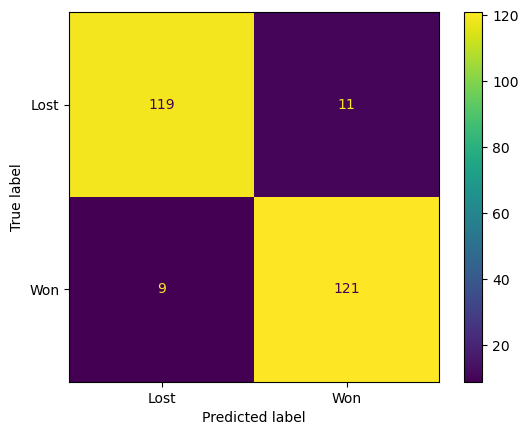

In [48]:
vecModel = runClfVectorModel(trainX, trainY, testX, testY)

In [49]:
dump(vecModel, 'models/vecModel1.joblib')

['models/vecModel1.joblib']

Best Parameters: {'clf__kernel': 'poly', 'scaler': MinMaxScaler()}
Best Model Validation Score 0.9289894866724134
Test Accuracy: 0.9346153846153846
Classification Report

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       130
           1       0.94      0.93      0.93       130

    accuracy                           0.93       260
   macro avg       0.93      0.93      0.93       260
weighted avg       0.93      0.93      0.93       260



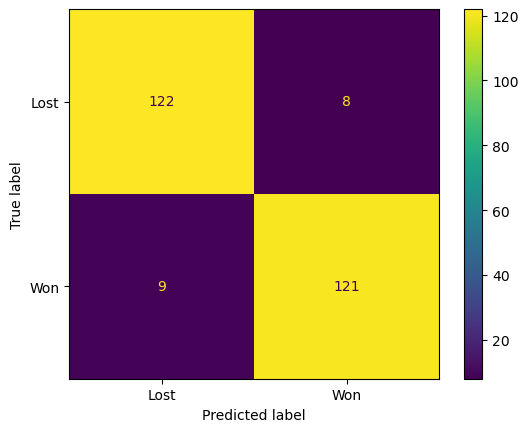

In [50]:
vecModel2 = runClfVectorModel(trainX2, trainY2, testX2, testY2)

In [51]:
dump(vecModel2, 'models/vecModel2.joblib')

['models/vecModel2.joblib']

In [52]:
stats = {'FTP': 83.3, 'ASTR': 0.6451612903225806, 'TASTR': 0.33178500331785005, 'ATR': 20.0, 'FTR': 0.2222222222222222, 'FTCR': 18.51111111111111, 'FGP': 57.4, 'FGRR': 0.07407407407407407, 'FGPD': 15.199999999999996, 'ASTRD': 0.3118279569892473, 'TASTRD': 0.2026972236276607, 'FTRD': 0.01909722222222221, 'FTCRD': 4.454861111111109, '2PPD': 1.8999999999999986, '3PPD': 37.5, 'FTPD': 14.099999999999994, 'FGRRD': -0.09780092592592593}


In [57]:
dd = pd.DataFrame([stats])

In [60]:
trainX

,FTP,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD
1068,0.647059,0.608696,0.176145,0.933333,0.298246,0.192982,0.403509,0.192982,-0.107130,-0.099638,-0.054959,-0.212393,-0.232549,-0.288978,0.080268,-0.186275,0.065323
1069,0.833333,0.708333,0.231104,1.062500,0.510638,0.425532,0.510638,0.127660,0.107130,0.099638,0.054959,0.212393,0.232549,0.288978,-0.080268,0.186275,-0.065323
38,0.812500,0.375000,0.159915,1.200000,0.275862,0.224138,0.551724,0.189655,0.107280,-0.025000,0.046729,-0.213027,-0.198084,0.074013,0.219231,-0.051136,0.056322
39,0.863636,0.400000,0.113186,0.500000,0.488889,0.422222,0.444444,0.133333,-0.107280,0.025000,-0.046729,0.213027,0.198084,-0.074013,-0.219231,0.051136,-0.056322
3443,0.774194,0.600000,0.125628,0.500000,0.775000,0.600000,0.375000,0.100000,0.012931,-0.161905,-0.080239,0.550862,0.410345,0.055703,-0.281250,-0.071960,-0.089655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11748,0.909091,0.451613,0.179856,1.272727,0.177419,0.161290,0.500000,0.145161,0.032258,-0.031146,-0.000649,-0.209677,-0.161290,0.202341,-0.320652,0.075758,-0.016129
13162,0.666667,0.333333,0.116189,1.090909,0.137931,0.091954,0.413793,0.114943,0.018444,-0.137255,-0.031195,-0.141139,-0.105720,-0.093706,0.215543,-0.041667,-0.024592
13163,0.708333,0.470588,0.147384,1.333333,0.279070,0.197674,0.395349,0.139535,-0.018444,0.137255,0.031195,0.141139,0.105720,0.093706,-0.215543,0.041667,0.024592
13150,0.740741,0.655172,0.216204,2.375000,0.397059,0.294118,0.426471,0.279412,-0.051790,0.352142,0.097664,0.121697,0.062234,-0.097132,0.045455,-0.101365,0.076513


In [61]:
from sklearn.neural_network import MLPRegressor

In [122]:
def runNNRModel(layerSizes,trainX, trainY, testX, testY):
    MLPR_Pipeline = Pipeline(steps = [('scaler', StandardScaler()),('clf', MLPRegressor(max_iter=500))])
    MLPR_Pipeline_Param_Grid = {
        'scaler' : [StandardScaler(), MinMaxScaler()],
        'clf__activation' : ['logistic','tanh','relu'],
        'clf__hidden_layer_sizes': layerSizes
    }
    
    MLPR_PipelineCV = GridSearchCV(MLPR_Pipeline,MLPR_Pipeline_Param_Grid,refit=True,verbose=1)
    MLPR_PipelineCV.fit(trainX,trainY)
    
    print('Best Parameters:',MLPR_PipelineCV.best_params_)
    print('Best Model Validation Score',MLPR_PipelineCV.best_score_)
    
    y_pred = MLPR_PipelineCV.predict(testX)
    
    getRegMetrics(testY,y_pred)
    
    return MLPR_PipelineCV.best_estimator_

In [96]:
MLP_Model_Sizes = [(30,50,15),(20,60,20),(20,60,60,20)]

In [97]:
NNRModel1 = runNNRModel(MLP_Model_Sizes, trainX, trainY, testX, testY)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'clf__hidden_layer_sizes': (20, 60, 20), 'scaler': StandardScaler()}
Best Model Validation Score 0.8231035758002276
Test R^2 score: 0.7180733178568433
Test MAE Loss: 0.1265624572871108
Test MSE Loss: 0.0704816705357892


In [66]:
NNRModel1

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPRegressor(activation='logistic',
                              hidden_layer_sizes=(30, 50, 15)))])

In [98]:
NNRModel1.feature_names_in_

array(['FTP', 'ASTR', 'TASTR', 'ATR', 'FTR', 'FTCR', 'FGP', 'FGRR',
       'FGPD', 'ASTRD', 'TASTRD', 'FTRD', 'FTCRD', '2PPD', '3PPD', 'FTPD',
       'FGRRD'], dtype=object)

In [99]:
testX.columns

Index(['FTP', 'ASTR', 'TASTR', 'ATR', 'FTR', 'FTCR', 'FGP', 'FGRR', 'FGPD',
       'ASTRD', 'TASTRD', 'FTRD', 'FTCRD', '2PPD', '3PPD', 'FTPD', 'FGRRD'],
      dtype='object')

In [100]:
set(NNRModel1.feature_names_in_ == testX.columns) == {True}

True

In [101]:
NNRModel1.predict(testX)

array([ 1.00281981e+00, -9.56634372e-03, -4.43264598e-02,  1.01952851e+00,
        1.03227049e+00, -5.77407022e-02,  5.26338356e-01,  5.14025391e-01,
       -4.10411925e-02,  1.00693701e+00,  4.56316803e-01,  4.25427461e-01,
        2.93533223e-01,  6.00487816e-01,  1.01360762e+00, -2.42776462e-02,
        9.81440346e-01,  1.23619644e-02,  1.01347998e+00, -1.96997445e-02,
        2.18197492e-01,  7.23909687e-01,  4.31922455e-01,  4.21692457e-01,
        1.00749120e+00,  8.71580851e-02, -2.98016364e-02,  1.01852367e+00,
        9.80518432e-01, -4.28959546e-02,  4.51731586e-02,  9.93539187e-01,
       -3.76124095e-01,  4.41569661e-01,  9.99580216e-01, -4.21030064e-02,
        1.01321921e+00,  9.86520384e-01, -3.17096121e-02,  1.00686824e+00,
        1.01756083e+00,  4.24780286e-04, -3.90178168e-02,  9.82577899e-01,
        1.18012238e+00, -1.10171899e-01,  1.01333647e+00, -3.37197374e-02,
        1.63974274e-01,  9.74804643e-01,  5.92573393e-01,  1.78550578e-01,
        9.91755567e-01, -

In [102]:
np.sort(1/(1+np.exp(-NNRModel1.predict(testX))))

array([0.40706206, 0.45815655, 0.45852777, 0.46146302, 0.47248485,
       0.47857617, 0.47965882, 0.48009927, 0.48146192, 0.48237522,
       0.48281989, 0.48556883, 0.48566284, 0.48615167, 0.48636744,
       0.48688173, 0.48705783, 0.48814158, 0.48869058, 0.4889202 ,
       0.48892582, 0.48927766, 0.48928269, 0.4894758 , 0.4895249 ,
       0.48964134, 0.48974114, 0.49022009, 0.49024678, 0.49065471,
       0.49115033, 0.49117981, 0.49157086, 0.49161007, 0.49189088,
       0.49205213, 0.49207326, 0.49210961, 0.49216452, 0.49241255,
       0.49245458, 0.49246707, 0.49248926, 0.49255014, 0.49259085,
       0.49259957, 0.49262669, 0.49268389, 0.49345518, 0.4934577 ,
       0.49370189, 0.49392377, 0.49393089, 0.49396561, 0.49399681,
       0.49414886, 0.49427244, 0.49468726, 0.49507522, 0.49526132,
       0.49528113, 0.49543514, 0.49549852, 0.49550555, 0.49563786,
       0.49572113, 0.49595889, 0.49608213, 0.49653133, 0.49675416,
       0.49691206, 0.49711639, 0.49719875, 0.49729001, 0.49748

In [106]:
testN = test

In [108]:
testN['pred'] = 1/(1+np.exp(-NNRModel1.predict(test[features])))

In [111]:
testN[['FixtureKey','IsWinner','pred']]

,FixtureKey,IsWinner,pred
113,ABILCH v UT VAL 25-Feb-2023,1,0.731613
112,ABILCH v UT VAL 25-Feb-2023,0,0.497608
89,AKRON v W MICH 25-Feb-2023,0,0.488920
88,AKRON v W MICH 25-Feb-2023,1,0.734881
228,ALA ST v AL A&M 25-Feb-2023,1,0.737356
...,...,...,...
24,WM&MRY v MONMTH 25-Feb-2023,0,0.493458
92,WOFFRD v CHAT 25-Feb-2023,0,0.489641
93,WOFFRD v CHAT 25-Feb-2023,1,0.734227
184,YALE v CORN 25-Feb-2023,0,0.492165


In [112]:
pd.options.display.max_rows = 999

In [113]:
testN[['FixtureKey','IsWinner','pred']]

,FixtureKey,IsWinner,pred
113,ABILCH v UT VAL 25-Feb-2023,1,0.731613
112,ABILCH v UT VAL 25-Feb-2023,0,0.497608
89,AKRON v W MICH 25-Feb-2023,0,0.488920
88,AKRON v W MICH 25-Feb-2023,1,0.734881
228,ALA ST v AL A&M 25-Feb-2023,1,0.737356
229,ALA ST v AL A&M 25-Feb-2023,0,0.485569
141,ALA v ARK 25-Feb-2023,0,0.628629
140,ALA v ARK 25-Feb-2023,1,0.625750
193,ALBANY v NJIT 25-Feb-2023,0,0.489741
192,ALBANY v NJIT 25-Feb-2023,1,0.732420


In [118]:
testN.loc[testN['FixtureKey'] == 'MIAMI v FSU 25-Feb-2023']

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,...,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD,pred
199,MIAMI v FSU 25-Feb-2023,1,26,45,8,19,8,11,7,24,...,0.00744,-0.016043,-0.001889,-0.050347,-0.065476,-0.026873,0.071053,-0.12987,0.03001,0.592625
198,MIAMI v FSU 25-Feb-2023,2,26,43,7,20,12,14,5,25,...,-0.00744,0.016043,0.001889,0.050347,0.065476,0.026873,-0.071053,0.12987,-0.03001,0.570804


In [119]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [120]:
testN.loc[testN['FixtureKey'] == 'MIAMI v FSU 25-Feb-2023']

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,IsWinner,TeamHandicap,2PP,3PP,FTP,FGA,FGM,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD,pred
199,MIAMI v FSU 25-Feb-2023,1,26,45,8,19,8,11,7,24,18,7,2,12,12,84,0,-14.0,0.577778,0.421053,0.727273,64,34,0.529412,0.222662,1.500000,0.171875,0.125000,0.53125,0.109375,0.00744,-0.016043,-0.001889,-0.050347,-0.065476,-0.026873,0.071053,-0.12987,0.03001,0.592625
198,MIAMI v FSU 25-Feb-2023,2,26,43,7,20,12,14,5,25,18,10,6,11,12,85,1,14.0,0.604651,0.350000,0.857143,63,33,0.545455,0.224551,1.636364,0.222222,0.190476,0.52381,0.079365,-0.00744,0.016043,0.001889,0.050347,0.065476,0.026873,-0.071053,0.12987,-0.03001,0.570804


In [121]:
testN.loc[testN['FixtureKey'] == 'TXTECH v TCU 25-Feb-2023']

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,IsWinner,TeamHandicap,2PP,3PP,FTP,FGA,FGM,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD,pred
245,TXTECH v TCU 25-Feb-2023,1,23,40,7,20,15,21,11,20,13,3,2,12,10,82,0,-2.0,0.575000,0.350000,0.714286,60,30,0.433333,0.160020,1.083333,0.350000,0.250000,0.500000,0.183333,0.014706,-0.142424,-0.066927,0.158824,0.088235,0.000532,0.064286,-0.131868,-0.007843,0.674911
244,TXTECH v TCU 25-Feb-2023,2,27,47,6,21,11,13,13,20,19,6,2,10,18,83,1,2.0,0.574468,0.285714,0.846154,68,33,0.575758,0.226947,1.900000,0.191176,0.161765,0.485294,0.191176,-0.014706,0.142424,0.066927,-0.158824,-0.088235,-0.000532,-0.064286,0.131868,0.007843,0.660284


In [123]:
NNRModel2 = runNNRModel(MLP_Model_Sizes, trainX, trainY, testX, testY)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (20, 60, 20), 'scaler': StandardScaler()}
Best Model Validation Score 0.8530516551178302
Test R^2 score: 0.7939184841238701
Test MAE Loss: 0.10620702758911175
Test MSE Loss: 0.051520378969032464


In [124]:
testN2 = test
testN2['pred'] = 1/(1+np.exp(-NNRModel2.predict(test[features])))
testN[['FixtureKey','IsWinner','pred']]

,FixtureKey,IsWinner,pred
113,ABILCH v UT VAL 25-Feb-2023,1,0.731835
112,ABILCH v UT VAL 25-Feb-2023,0,0.502509
89,AKRON v W MICH 25-Feb-2023,0,0.499203
88,AKRON v W MICH 25-Feb-2023,1,0.731457
228,ALA ST v AL A&M 25-Feb-2023,1,0.733614
229,ALA ST v AL A&M 25-Feb-2023,0,0.505383
141,ALA v ARK 25-Feb-2023,0,0.654705
140,ALA v ARK 25-Feb-2023,1,0.723844
193,ALBANY v NJIT 25-Feb-2023,0,0.497474
192,ALBANY v NJIT 25-Feb-2023,1,0.733538


In [125]:
testN2.rename(columns = {'pred':'pred_sigmoid'}, inplace = True)

In [126]:
testN[['FixtureKey','IsWinner','pred_sigmoid']]

,FixtureKey,IsWinner,pred_sigmoid
113,ABILCH v UT VAL 25-Feb-2023,1,0.731835
112,ABILCH v UT VAL 25-Feb-2023,0,0.502509
89,AKRON v W MICH 25-Feb-2023,0,0.499203
88,AKRON v W MICH 25-Feb-2023,1,0.731457
228,ALA ST v AL A&M 25-Feb-2023,1,0.733614
229,ALA ST v AL A&M 25-Feb-2023,0,0.505383
141,ALA v ARK 25-Feb-2023,0,0.654705
140,ALA v ARK 25-Feb-2023,1,0.723844
193,ALBANY v NJIT 25-Feb-2023,0,0.497474
192,ALBANY v NJIT 25-Feb-2023,1,0.733538


In [127]:
testN['pred_tanh'] = np.tanh(NNRModel2.predict(test[features])) - 0.5
testN[['FixtureKey','IsWinner','pred_sigmoid','pred_tanh']]

,FixtureKey,IsWinner,pred_sigmoid,pred_tanh
113,ABILCH v UT VAL 25-Feb-2023,1,0.731835,0.263249
112,ABILCH v UT VAL 25-Feb-2023,0,0.502509,-0.489965
89,AKRON v W MICH 25-Feb-2023,0,0.499203,-0.503187
88,AKRON v W MICH 25-Feb-2023,1,0.731457,0.262445
228,ALA ST v AL A&M 25-Feb-2023,1,0.733614,0.267015
229,ALA ST v AL A&M 25-Feb-2023,0,0.505383,-0.478470
141,ALA v ARK 25-Feb-2023,0,0.654705,0.064754
140,ALA v ARK 25-Feb-2023,1,0.723844,0.245884
193,ALBANY v NJIT 25-Feb-2023,0,0.497474,-0.510105
192,ALBANY v NJIT 25-Feb-2023,1,0.733538,0.266854


In [136]:
testN['correct'] = ((testN.loc[:,'IsWinner'] == 1) & (testN.loc[:,'pred_tanh'] > 0.0)) | ((testN.loc[:,'IsWinner'] == 0) & (testN.loc[:,'pred_tanh'] < 0.0))
                    

In [143]:
testN[testN['correct'] == False][['FixtureKey','Team','PTS','IsWinner','pred_tanh']]

,FixtureKey,Team,PTS,IsWinner,pred_tanh
141,ALA v ARK 25-Feb-2023,2,83,0,0.064754
212,ARIZ v AZ ST 25-Feb-2023,1,88,0,0.014852
213,ARIZ v AZ ST 25-Feb-2023,2,89,1,-0.107686
189,BINGHA v MAINE 25-Feb-2023,2,71,1,-0.228542
188,BINGHA v MAINE 25-Feb-2023,1,67,0,0.131204
124,FORDHM v URI 25-Feb-2023,1,74,1,-0.483015
125,FORDHM v URI 25-Feb-2023,2,71,0,0.192246
148,IOWA v MICHST 25-Feb-2023,1,112,1,-0.107239
149,IOWA v MICHST 25-Feb-2023,2,106,0,0.208344
199,MIAMI v FSU 25-Feb-2023,1,84,0,0.055448


In [141]:
len(testN[testN['correct'] == False])/len(testN)

0.07692307692307693

In [144]:
testN.corr()

/var/folders/b7/hbtzj39j4tng96ln0jphxwzr0000gn/T/ipykernel_19234/2207256794.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  testN.corr()


,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,IsWinner,TeamHandicap,2PP,3PP,FTP,FGA,FGM,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD,pred_sigmoid,pred_tanh,correct
Team,1.000000e+00,-0.049423,0.061694,-0.080100,-1.385780e-17,-0.094467,-0.095522,0.016756,-0.147737,-0.174342,0.043380,-0.149786,0.042481,0.046678,-0.146272,-2.000000e-01,0.249444,-0.144745,-0.098279,-0.046762,0.070652,-0.099085,-0.162865,-0.192628,-0.173540,-0.101862,-0.098973,-0.164229,-0.004873,-0.229272,-0.247384,-0.273411,-0.162060,-0.155789,-0.219324,-0.128495,-0.069533,-0.007080,-0.245460,-0.243757,-2.886751e-02
2PM,-4.942328e-02,1.000000,0.738518,-0.312412,-4.346069e-01,0.009527,-0.006614,0.143695,-0.006951,0.323442,0.202744,0.055944,-0.134661,0.047486,0.576374,2.001238e-01,-0.201649,0.569034,0.005754,0.028566,0.466096,0.809186,-0.149221,0.234071,0.276666,-0.149155,-0.120943,0.575679,0.018708,0.360778,-0.109351,0.173781,-0.162110,-0.169748,0.415876,-0.040491,-0.055647,-0.000385,0.217117,0.223596,-1.522622e-01
2PA,6.169398e-02,0.738518,1.000000,-0.485038,-5.370774e-01,-0.066909,-0.056429,0.429496,-0.006054,0.032868,0.220130,0.100263,-0.142464,0.081709,0.199661,-5.683618e-02,-0.018438,-0.114956,-0.117783,-0.062703,0.676030,0.440302,-0.270242,-0.101302,0.095151,-0.243767,-0.234705,0.014829,0.278999,-0.012398,-0.218938,-0.065737,-0.275659,-0.295577,-0.028995,-0.155172,-0.127151,0.148812,-0.058690,-0.053351,-1.370071e-01
3PM,-8.010003e-02,-0.312412,-0.485038,1.000000,6.884430e-01,-0.109402,-0.132387,-0.079089,0.024808,0.471481,-0.076322,-0.022743,-0.061863,-0.074592,0.438719,2.849460e-01,-0.206520,0.138796,0.630036,0.022446,0.045930,0.305344,0.393898,0.481472,0.315533,-0.134105,-0.112980,0.308556,-0.115783,0.216794,0.390328,0.399134,-0.068891,-0.064359,0.035912,0.489513,-0.007949,-0.079151,0.251838,0.255351,-1.137191e-01
3PA,-1.385780e-17,-0.434607,-0.537077,0.688443,1.000000e+00,-0.139128,-0.160508,0.197699,-0.017319,0.210449,-0.069048,-0.035958,-0.145645,-0.088328,0.093807,3.184184e-02,-0.076175,0.024412,-0.090968,0.006733,0.258497,-0.009848,0.274857,0.183700,0.194109,-0.232020,-0.206181,-0.208261,0.141689,-0.222095,0.232413,0.103183,-0.168874,-0.135515,-0.104921,-0.069684,0.036553,0.205859,-0.046028,-0.047770,6.434363e-03
FTM,-9.446688e-02,0.009527,-0.066909,-0.109402,-1.391283e-01,1.000000,0.940671,0.012712,0.083575,-0.062771,0.154547,0.083128,0.195110,0.412541,0.422827,1.640050e-01,-0.077406,0.079001,0.021935,0.368009,-0.198161,-0.058116,-0.029115,-0.150720,-0.172891,0.887755,0.956586,0.079208,0.085790,0.030575,-0.062684,-0.109786,0.509861,0.553769,0.063857,-0.004565,0.235613,0.010173,0.232106,0.233983,-1.533951e-02
FTA,-9.552230e-02,-0.006614,-0.056429,-0.132387,-1.605084e-01,0.940671,1.000000,0.036628,0.089965,-0.080740,0.165224,0.082653,0.173567,0.423077,0.363278,1.456849e-01,-0.102453,0.044802,0.022272,0.063546,-0.204836,-0.088512,-0.028924,-0.170085,-0.175773,0.947595,0.907716,0.051533,0.113753,0.034765,-0.047160,-0.093962,0.544198,0.502423,0.050481,0.017361,0.020356,0.004773,0.217743,0.218441,-3.389095e-03
ORB,1.675638e-02,0.143695,0.429496,-0.079089,1.976995e-01,0.012712,0.036628,1.000000,-0.040081,-0.026406,0.058577,0.166209,0.012771,-0.020943,0.063003,-6.516369e-02,-0.068745,-0.281868,-0.293266,-0.088792,0.664559,0.095125,-0.100311,-0.189116,-0.025368,-0.158033,-0.158646,-0.360311,0.958393,-0.305112,-0.080038,-0.147341,-0.221687,-0.207738,-0.178094,-0.292182,-0.027528,0.671757,-0.128899,-0.129704,-6.718263e-03
DRB,-1.477375e-01,-0.006951,-0.006054,0.024808,-1.731946e-02,0.083575,0.089965,-0.040081,1.000000,0.014769,-0.200830,0.268509,0.143655,0.016442,0.054377,3.612220e-01,-0.204994,0.001380,0.082167,0.022316,-0.022062,0.008377,0.027466,-0.002433,-0.046001,0.093080,0.091659,0.025939,-0.041398,0.511848,0.093549,0.235566,0.177003,0.236463,0.447571,0.342588,0.223438,0.033669,0.397861,0.393037,4.599747e-02
AST,-1.743423e-01,0.323442,0.032868,0.471481,2.104493e-01,-0.062771,-0.080740,-0.026406,0.014769

In [145]:
testN2.rename(columns = {'correct':'correct_tanh'}, inplace = True)

In [148]:
testN['correct_sigmoid'] = ((testN.loc[:,'IsWinner'] == 1) & (testN.loc[:,'pred_sigmoid'] > 0.5)) | ((testN.loc[:,'IsWinner'] == 0) & (testN.loc[:,'pred_sigmoid'] < 0.5))


In [151]:
len(testN[testN['correct_sigmoid'] == True])/len(testN)

0.6884615384615385

In [150]:
testN

,FixtureKey,Team,2PM,2PA,3PM,3PA,FTM,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,IsWinner,TeamHandicap,2PP,3PP,FTP,FGA,FGM,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD,pred_sigmoid,pred_tanh,correct_tanh,correct_sigmoid
113,ABILCH v UT VAL 25-Feb-2023,2,23,40,4,14,8,10,5,29,15,6,4,15,12,66,1,-2.0,0.575000,0.285714,0.800000,54,27,0.555556,0.204360,1.000000,0.185185,0.148148,0.500000,0.092593,0.122951,0.033816,0.055328,0.054038,4.978749e-02,0.168750,-0.059113,0.050000,-0.071342,0.731835,0.263249,True,True
112,ABILCH v UT VAL 25-Feb-2023,1,13,32,10,29,6,8,10,24,12,9,5,16,17,62,0,2.0,0.406250,0.344828,0.750000,61,23,0.521739,0.149031,0.750000,0.131148,0.098361,0.377049,0.163934,-0.122951,-0.033816,-0.055328,-0.054038,-4.978749e-02,-0.168750,0.059113,-0.050000,0.071342,0.502509,-0.489965,True,False
89,AKRON v W MICH 25-Feb-2023,2,10,20,12,39,8,10,9,23,7,3,0,12,13,64,0,15.0,0.500000,0.307692,0.800000,59,22,0.318182,0.092838,0.583333,0.169492,0.135593,0.372881,0.152542,-0.154391,-0.440439,-0.237492,-0.103236,-4.622496e-02,-0.195652,-0.098558,0.133333,0.079815,0.499203,-0.503187,True,True
88,AKRON v W MICH 25-Feb-2023,1,16,23,13,32,10,15,4,27,22,7,2,5,14,81,1,-15.0,0.695652,0.406250,0.666667,55,29,0.758621,0.330330,4.400000,0.272727,0.181818,0.527273,0.072727,0.154391,0.440439,0.237492,0.103236,4.622496e-02,0.195652,0.098558,-0.133333,-0.079815,0.731457,0.262445,True,True
228,ALA ST v AL A&M 25-Feb-2023,2,14,32,5,16,12,21,7,24,10,7,4,10,13,55,1,0.0,0.437500,0.312500,0.571429,48,19,0.526316,0.148721,1.000000,0.437500,0.250000,0.395833,0.145833,0.095833,-0.029240,0.016306,0.304167,1.666667e-01,0.137500,0.012500,-0.053571,-0.170833,0.733614,0.267015,True,True
229,ALA ST v AL A&M 25-Feb-2023,1,9,30,9,30,5,8,19,27,10,4,2,12,14,50,0,0.0,0.300000,0.300000,0.625000,60,18,0.555556,0.132415,0.833333,0.133333,0.083333,0.300000,0.316667,-0.095833,0.029240,-0.016306,-0.304167,-1.666667e-01,-0.137500,-0.012500,0.053571,0.170833,0.505383,-0.478470,True,False
141,ALA v ARK 25-Feb-2023,2,24,60,5,10,20,29,13,24,6,12,6,11,25,83,0,8.5,0.400000,0.500000,0.689655,70,29,0.206897,0.063993,0.545455,0.414286,0.285714,0.414286,0.185714,-0.038839,-0.241379,-0.074011,-0.054464,-1.049107e-01,-0.219048,0.363636,-0.143678,-0.033036,0.654705,0.064754,False,False
140,ALA v ARK 25-Feb-2023,1,26,42,3,22,25,30,14,34,13,6,4,17,21,86,1,-8.5,0.619048,0.136364,0.833333,64,29,0.448276,0.138004,0.764706,0.468750,0.390625,0.453125,0.218750,0.038839,0.241379,0.074011,0.054464,1.049107e-01,0.219048,-0.363636,0.143678,0.033036,0.723844,0.245884,True,True
193,ALBANY v NJIT 25-Feb-2023,2,18,38,8,20,8,13,7,21,12,4,1,9,18,68,0,1.5,0.473684,0.400000,0.615385,58,26,0.461538,0.165017,1.333333,0.224138,0.137931,0.448276,0.120690,0.009679,0.061538,0.037335,-0.267090,-2.655777e-01,-0.042445,0.053846,-0.206044,-0.107381,0.497474,-0.510105,True,True
192,ALBANY v NJIT 25-Feb-2023,1,16,31,9,26,23,28,13,28,10,6,1,9,16,82,1,-1.5,0.516129,0.346154,0.821429,57,25,0.400000,0.127681,1.111111,0.491228,0.403509,0.438596,0.228070,-0.009679,-0.061538,-0.037335,0.267090,2.655777e-01,0.042445,-0.053846,0.206044,0.107381,0.733538,0.266854,True,True


In [152]:
len(testN[testN['correct_tanh'] == True])/len(testN)

0.9230769230769231

In [154]:
dump(NNRModel2, 'models/NNRModel2.joblib')

['models/NNRModel2.joblib']

In [155]:
dd

,FTP,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD
0,83.3,0.645161,0.331785,20.0,0.222222,18.511111,57.4,0.074074,15.2,0.311828,0.202697,0.019097,4.454861,1.9,37.5,14.1,-0.097801


In [156]:
NNRModel2.predict(dd)

array([1.01525052])

In [164]:
np.tanh(NNRModel2.predict(dd)) - 0.5

array([0.26792496])

In [159]:
wildcat = pd.DataFrame([{'FTP': 69.2, 'ASTR': 0.3333333333333333, 'TASTR': 0.12908777969018934, 'ATR': 9, 'FTR': 0.203125, 'FTCR': 14.05625, 'FGP': 42.2, 'FGRR': 0.171875, 'FGPD': -15.199999999999996, 'ASTRD': -0.3118279569892473, 'TASTRD': -0.2026972236276607, 'FTRD': -0.01909722222222221, 'FTCRD': -4.454861111111109, '2PPD': -1.8999999999999986, '3PPD': -37.5, 'FTPD': -14.099999999999994, 'FGRRD': 0.09780092592592593}])

In [160]:
wildcat

,FTP,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD
0,69.2,0.333333,0.129088,9,0.203125,14.05625,42.2,0.171875,-15.2,-0.311828,-0.202697,-0.019097,-4.454861,-1.9,-37.5,-14.1,0.097801


In [163]:
np.tanh(NNRModel2.predict(wildcat[features])) - 0.5

array([0.30883786])

In [162]:
NNRModel2

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 MLPRegressor(activation='tanh',
                              hidden_layer_sizes=(20, 60, 20), max_iter=500))])

In [165]:
neb = pd.DataFrame([{'FTP': 84.2,
   'ASTR': 0.7586206896551724,
   'TASTR': 0.33152501506931886,
   'ATR': 22.0,
   'FTR': 0.3333333333333333,
   'FTCR': 28.066666666666666,
   'FGP': 50.9,
   'FGRR': 0.07017543859649122,
   'FGPD': 8.799999999999997,
   'ASTRD': 0.050287356321839005,
   'TASTRD': 0.06836712033247672,
   'FTRD': 0.07017543859649122,
   'FTCRD': 8.777192982456143,
   '2PPD': -1.6999999999999957,
   '3PPD': 21.5,
   'FTPD': 10.900000000000006,
   'FGRRD': -0.08771929824561403}])[features]

In [166]:
neb

,FTP,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD
0,84.2,0.758621,0.331525,22.0,0.333333,28.066667,50.9,0.070175,8.8,0.050287,0.068367,0.070175,8.777193,-1.7,21.5,10.9,-0.087719


In [167]:
np.tanh(NNRModel2.predict(neb)) - 0.5

array([0.21829244])

In [168]:
boi = pd.DataFrame([{'FTP': 73.3,
   'ASTR': 0.7083333333333334,
   'TASTR': 0.26315789473684215,
   'ATR': 17.0,
   'FTR': 0.2631578947368421,
   'FTCR': 19.289473684210524,
   'FGP': 42.1,
   'FGRR': 0.15789473684210525,
   'FGPD': -8.799999999999997,
   'ASTRD': -0.050287356321839005,
   'TASTRD': -0.06836712033247672,
   'FTRD': -0.07017543859649122,
   'FTCRD': -8.777192982456143,
   '2PPD': 1.6999999999999957,
   '3PPD': -21.5,
   'FTPD': -10.900000000000006,
   'FGRRD': 0.08771929824561403}])[features]

In [169]:
np.tanh(NNRModel2.predict(boi)) - 0.5

array([0.22158095])

In [172]:
NNRModel2.predict(wildcat)

array([1.12365895])

In [173]:
print(vecModel.predict(wildcat))
print(vecModel.predict(neb))
print(vecModel.predict(boi))

[1]
[1]
[1]


In [174]:
print(vecModel2.predict(wildcat[features2]))
print(vecModel2.predict(neb[features2]))
print(vecModel2.predict(boi[features2]))

[1]
[0]
[1]


In [179]:
car = pd.DataFrame([{'FTP': 83.3, 'ASTR': 0.6451612903225806, 'TASTR': 0.33178500331785005, 'ATR': 20.0, 'FTR': 0.2222222222222222, 'FTCR': 18.51111111111111, 'FGP': 57.4, 'FGRR': 0.07407407407407407, 'FGPD': 15.199999999999996, 'ASTRD': 0.3118279569892473, 'TASTRD': 0.2026972236276607, 'FTRD': 0.01909722222222221, 'FTCRD': 4.454861111111109, '2PPD': 1.8999999999999986, '3PPD': 37.5, 'FTPD': 14.099999999999994, 'FGRRD': -0.09780092592592593}])
   

In [180]:
car

,FTP,ASTR,TASTR,ATR,FTR,FTCR,FGP,FGRR,FGPD,ASTRD,TASTRD,FTRD,FTCRD,2PPD,3PPD,FTPD,FGRRD
0,83.3,0.645161,0.331785,20.0,0.222222,18.511111,57.4,0.074074,15.2,0.311828,0.202697,0.019097,4.454861,1.9,37.5,14.1,-0.097801


In [181]:
print(vecModel2.predict(car[features2]))

[0]


In [182]:
print(vecModel2.predict(pd.DataFrame([{'FTP': 69.2, 'ASTR': 0.3333333333333333, 'TASTR': 0.12908777969018934, 'ATR': 9, 'FTR': 0.203125, 'FTCR': 14.05625, 'FGP': 42.2, 'FGRR': 0.171875, 'FGPD': -15.199999999999996, 'ASTRD': -0.3118279569892473, 'TASTRD': -0.2026972236276607, 'FTRD': -0.01909722222222221, 'FTCRD': -4.454861111111109, '2PPD': -1.8999999999999986, '3PPD': -37.5, 'FTPD': -14.099999999999994, 'FGRRD': 0.09780092592592593}])[features2]))


[1]


In [183]:
vecModel2

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', SVC(kernel='poly'))])

In [188]:
not vecModel2.predict(car[features2])[0]

True

In [189]:
vecModel2.feature_names_in_

array(['FGPD', 'ASTRD', 'TASTRD', 'FTRD', 'FTCRD', '2PPD', '3PPD', 'FTPD',
       'FGRRD'], dtype=object)